# Aprendizaje Reforzado (RL)

In [ ]:
# Importamos las librerias necesarias
%matplotlib inline

import time
import main_agent
import ten_arm_env
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from rlglue.rl_glue import RLGlue

## Toma de decisiones secuencial

En RL, el agente genera sus propios datos de entrenamiento al interactuar con el mundo. El agente debe aprender las consecuencias de sus propias acciones por ensayo y error, en lugar de que le digan la acción correcta en cada paso. A continuación presentaremos el siguiente que permite dar claridad a lo anteriormente mencionado:

Un niño está eligiendo su comida favorita. A continuación se plantea el siguiente objetivo: al presionar un boton en la aplicación se ejecutará un algoritmo el cual va a seleccionar una comida aleatoria y luego la aplicación calificará con un emoji para proseguir con la generación de la orden. Después de un tiempo, se comenzará a preferir un tipo de comida y, de cierto momento en adelante, solo come ese tipo de comida o continúa con la selección aleatoria y explorando sus opciones. Si solo come un tipo de comida, no podrá recopilar datos sobre las otras opciones gastronómicas.

En nuestro ejemplo, el agente es el niño, y las $k$ acciones diferentes son los diferentes tipos de comida que podría pedir. Cada elección de acción o tipo de comida generará una recompensa diferente.

<img src='grafico_ejercicio.png'>


### Action-Values 


Para que nuestro agente decida qué acción es óptima o mejor, sabemos la recompensa de tomar esa acción. A este mapeo lo llamamos **función acción-valor**:


\begin{equation*}
\Huge
Q_*(a)  \doteq \mathbb{E}[R_t|A_t=a]   \forall a \in {1,\dots,k}
\end{equation*}


\begin{equation*}
\Huge
= \sum_r p(r|a)\times r
\end{equation*}

La función acción-valor óptima se define como la recompensa esperada al realizar una acción $a_i$ para cada posible acción $i\in\{1,\dots,k\}$. El objetivo de nuestro agente es que se maximice la expectativa de recompensa:

\begin{equation*}
\DeclareMathOperator*{\argmax}{arg\,max}
\Huge
\argmax\limits_{a} Q_*(a)
\end{equation*}

### Ejemplo del promedio de muestra

Sin embargo, en realidad no conocemos esta función. $Q_*$! es *desconocida* para nuestro agente, ya que al principio no tenemos ninguna información. Una forma posible de estimar la función acción-valor es:

\begin{equation*}
\Huge
Q(a) \doteq \frac{\text{suma de los pesos en donde $a$ se toma antes de un tiempo $t$}}{\text{Número de veces que tomamos $a$ antes de tiempo $t$}}
\end{equation*}



\begin{equation*}
\Huge
= \frac{\sum_{i=1}^{t-1}R_i}{t-1}
\end{equation*}

Para nuestro ejemplo generaremos un algoritmo con un agente, el cual recibe una recompensa de 1 si le gusta la comida que probó en ese momento en particular y 0 en caso contrario.

Para esto, primero cargaremos los datos y crearemos el dataframe; posteriormente generaremos nuestra estimación de la función de valor de acción  anterior para 5786 registros de nuestro dataset.

In [2]:
data = pd.read_excel('/Users/karlaorozco/Desktop/RL/dataset.xls')

In [3]:
# Creamos dataframe
df = pd.DataFrame(data) 

df

,pollo_frito,pizza,hamburguesa,lagsana
0,0.0,1.0,NaN,NaN
1,0.0,1.0,1.0,1.0
2,0.0,1.0,NaN,NaN
3,NaN,1.0,0.0,NaN
4,NaN,1.0,0.0,NaN
...,...,...,...,...
5781,NaN,NaN,1.0,0.0
5782,NaN,NaN,1.0,0.0
5783,NaN,0.0,NaN,NaN
5784,NaN,0.0,NaN,NaN


In [4]:
df['pollo_frito'] = df['pollo_frito'].fillna(0)
df['pizza'] = df['pizza'].fillna(0)
df['hamburguesa'] = df['hamburguesa'].fillna(0)
df['lagsana'] = df['hamburguesa'].fillna(0)
df

,pollo_frito,pizza,hamburguesa,lagsana
0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
5781,0.0,0.0,1.0,1.0
5782,0.0,0.0,1.0,1.0
5783,0.0,0.0,0.0,0.0
5784,0.0,0.0,0.0,0.0


In [5]:
df.mean()

pollo_frito    0.248877
pizza          0.161770
hamburguesa    0.178362
lagsana        0.178362
dtype: float64

A medida que el agente tome más acciones, nuestras estimaciones se acercarán cada vez más a los valores reales de $Q_*$. Generalizando el cálculo anterior, podemos realizar un seguimiento del promedio de muestra de nuestras recompensas de la siguiente manera:


\begin{equation*}
\Huge
Q_{n+1}= \frac{1}{n}\sum_{i=1}^{n}R_i
\end{equation*}

Sacamos la recompensa actual de la suma:


\begin{equation*}
\Huge
= \frac{1}{n}(R_n + \sum_{i=1}^{n-1}R_i)
\end{equation*}

Escribimos el próximo valor estimado en términos del valor estimado anterior; para esto, multiplicamos y dividimos por $n - 1$:


\begin{equation*}
\Huge
= \frac{1}{n}(R_n + (n-1) \frac{1}{n-1}\sum_{i=1}^{n-1}R_i)
\end{equation*}

El último término es nuestra estimación de valor actual:


\begin{equation*}
\Huge
= \frac{1}{n}(R_n + (n-1) Q_n)
\end{equation*}

ahora, terminamos actualizando la función de valor de acción; esto se conoce como la **regla de actualización incremental**:


\begin{equation*}
\Huge
Q_{n+1}= Q_n + \frac{1}{n}(R_n - Q_n)
\end{equation*}


\begin{equation*}
\Large
    \text{Nueva estimación}=\text{Vieja estimación}+\text{Tamaño del paso}[\text{Etiqueta - Vieja estimación}]
\end{equation*}

### Selección de la acción 

En realidad, el agente no elegiría una acción al azar. Más bien, elegiría lo que cree que es la mejor comida de acuerdo con su experiencia hasta ese momento. Este método de elección de acciones se conoce como **codicioso** con enfoque de selección de acciones. 

Si el agente solo elige la acción codiciosa, esto se consideraría una **explotación** acercada. Sin embargo, también podría elegir acciones no codiciosas con cierta probabilidad. $\epsilon$ para obtener más información sobre los otros valores de acción esto se conoce como **exploración**. Una combinación de ambos es formalmenta llamada un **$\epsilon$-metodo codicioso**.

Adicionalmente tambien existe un problema llamdo **k-Problema de bandidos malos**. 

Solucionaremos este problema, pero primero debemos entender que en este problema tenemos un agente que elige entre 𝑘
k-diferentes acciones, y recibe una recompensa de acuerdo a la acción que elige. En el ejercicio se cumplen las siguientes condiciones:

* el **agente es el niño** 

* las **k-diferentes acciones son los diferentes tipos de comida que podría pedir**

* Cada elección de acción o tipo de comida, generará una recompensa diferente

### Para poder ver la diferencia entre otros modelos solucionaremos el $k$-problema de bandidos armados

### Agente codicioso

Primero implementamos un agente que adopte un enfoque codicioso.

Inicialmente vamos a implementar la función argmax, que toma una lista de valores de acción y devuelve una acción con el valor más alto. 

Implementamos nuestra función en lugar de usar la función argmax que usa `numpy`; debido a que la función argmax de `numpy` devuelve la primera instancia del valor más alto.

No queremos que lo anterior suceda; ya que sesga al agente a elegir una acción específica en el caso de empates. En su lugar, queremos romper los lazos entre los valores más altos al azar:

In [6]:
def our_argmax(q_values):
    """
    Entrada: lista de q_values 
    Retorno: Índice del elemento con el valor más alto. Rompe empates al azar.
    """
    value = float("-inf")
    breaks = []
    
    for i in range(len(q_values)):
        if q_values[i]>value:
            value=q_values[i]
            breaks = []
        if q_values[i]==value:
            breaks.append(i)
    return np.random.choice(breaks)

Ahora presentamos la primera parte de un agente RL-Glue. Aquí vamos a crear un `GreedyAgent` o `Agente codicioso` y se implamentara el método `agent_step()`. Este método se llama cada vez que el agente da un paso. El método tiene que devolver la acción seleccionada por el agente. Este método también garantiza que las estimaciones del agente se actualicen en función de las señales que recibe del entorno:

In [7]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        La función agent_stpe toma una recompensa y observación y
         devuelve la acción que el agente elige en ese paso de tiempo.
        
         entrada
         recompensa: la recompensa que el agente obtiene del entorno después de la última acción.
         observación: El estado que observan los agentes.
         Devuelve: La acción elegida por el agente en el paso de tiempo actual.
        """
        #Número de veces que visitamos cada brazo (acción)
        self.arm_count[self.last_action]+=1
        
        #tamaño del paso
        step_size=1/self.arm_count[self.last_action]
        
        #actualización incremental de la regla
        self.q_values[self.last_action]=self.q_values[self.last_action]+step_size*(reward-self.q_values[self.last_action])
       
        present_action = our_argmax(self.q_values)

        self.last_action = present_action
        
        return present_action
        

Visualicemos el resultado. Aquí ejecutamos un experimento usando RL-Glue para probar nuestro agente:

100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 42.94it/s]


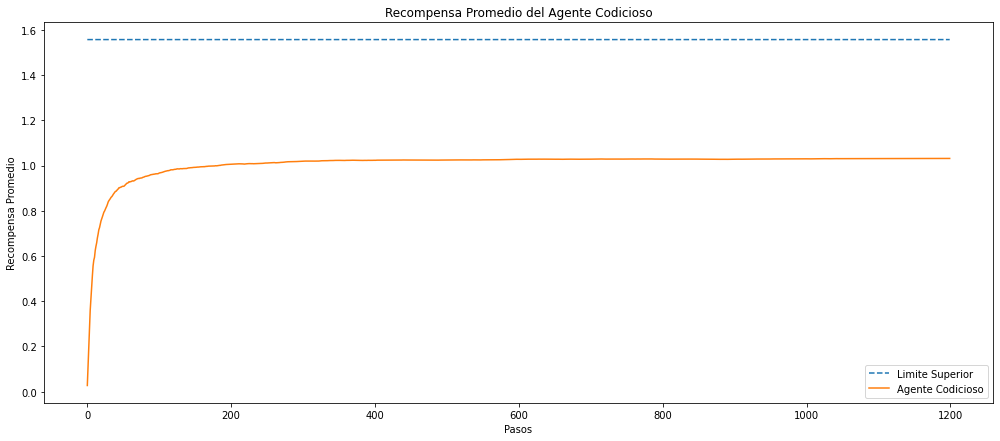

In [8]:
num_runs = 250                    # numero de veces que el experimento es ejecutado
num_steps = 1200                  # La cantidad de veces que nuestro agente come cada comida
env = ten_arm_env.Environment     # Diez entornos de bandidos armados con K (RLglue)
agent = GreedyAgent               # selección del agente
agent_info = {"num_actions": 10}  # Número de tipos de comida" que nuestro agente tiene
env_info = {}                     # Creamos el entorno vacío

my_averages = []

our_best_average = 0
for run in tqdm(range(num_runs)):           # tqdm es lo que crea la barra de progreso a continuación
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creamos un nuevo experimento RLGlue con el env y el agente que elegimos arriba
    rl_glue.rl_init(agent_info, env_info) # Pasamos a RLGlue sus requisitos para inicializar el agente y el entorno
    rl_glue.rl_start()                    # iniciamos

    our_best_average += np.max(rl_glue.environment.arms)
    
    score = [0]
    average = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # El entorno y el agente dan un paso y devuelven la recompensa, y se toman medidas.
        score.append(score[-1] + reward)
        average.append(score[-1] / (i + 1))
    my_averages.append(average)
y1=reward
plt.figure(figsize=(17, 7))
plt.plot([our_best_average / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(my_averages, axis=0))
plt.legend(["Limite Superior", "Agente Codicioso"])
plt.title("Recompensa Promedio del Agente Codicioso")
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.show()
greedy_average_reward = np.mean(my_averages, axis=0)

### $\epsilon$-agente codicioso

A continuación, modelaremos un agente que tome a $\epsilon$- de enfoque codicioso:

In [9]:
class eGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        La función agent_step toma una recompensa y observación y
         devuelve la acción que el agente elige en ese paso de tiempo.
        
         Entrada:
         recompensa: la recompensa que el agente recibió del entorno después de realizar la última acción.
         observación: el estado observado en el que se encuentra el agente.
         Devoluciones:
         acción_actual: la acción elegida por el agente en el paso de tiempo actual.
        """
        
        #Actualización del valor de la acción
        self.arm_count[self.last_action]+=1
        
        step_size=1/self.arm_count[self.last_action]
        
        #actualización incremental de la regla
        
        self.q_values[self.last_action]=self.q_values[self.last_action]+step_size*(reward-self.q_values[self.last_action])
        
        #selección de la acción (enfoque e-greedy)
        our_prob = np.random.random()
        if our_prob < self.epsilon:
            current_action = np.random.choice(self.num_actions)
        else:          
            current_action = our_argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

Visualizaremos el resultado a continuación; en donde ejecutamos un experimento usando RL-Glue para probar nuestro agente:

100%|███████████████████████████████████████████████████| 250/250 [00:05<00:00, 44.65it/s]


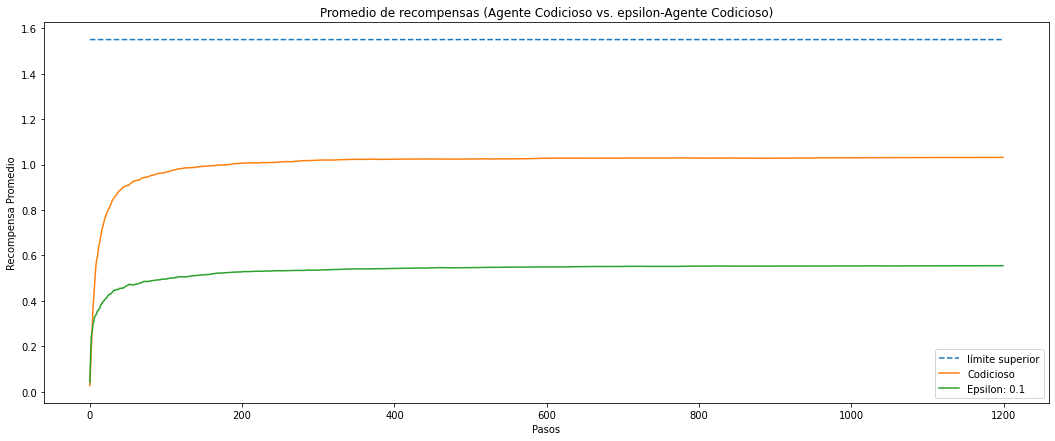

In [10]:
num_runs = 250
num_steps = 1200
epsilon = 0.1
agent = eGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_acciones": 10, "epsilon": epsilon}
env_info = {}
my_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() 
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    my_averages.append(averages)
y2=reward
plt.figure(figsize=(18, 7))
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_average_reward)
plt.title("Promedio de recompensas (Agente Codicioso vs. epsilon-Agente Codicioso)")
plt.plot(np.mean(my_averages, axis=0))
plt.legend(("límite superior", "Codicioso", "Epsilon: 0.1"))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.show()

### Promediar varias ejecuciones

Promediamos los resultados durante 250 ejecuciones. A continuacion se muetran los resultados de cuatro ejecuciones individuales realizadas por el mismo agente:

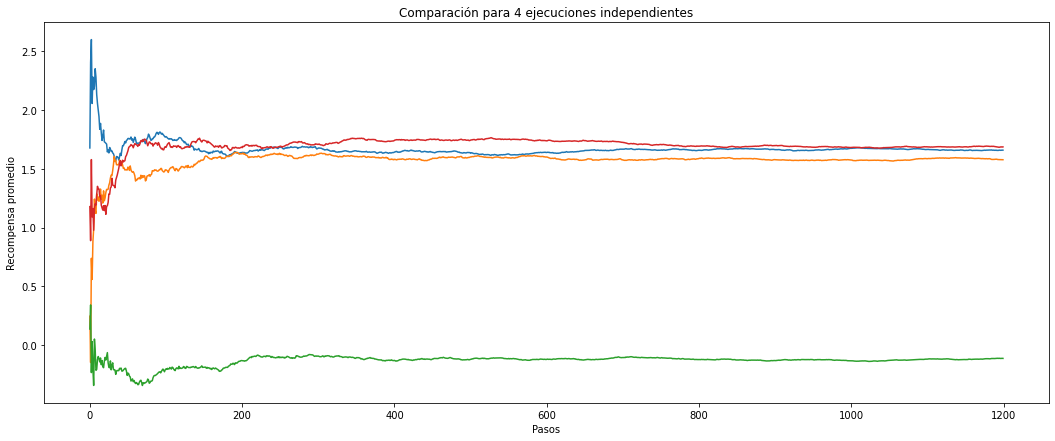

In [11]:
agent = eGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_acciones": 10, "epsilon": 0.1}
env_info = {}
plt.figure(figsize=(18, 7))
num_steps = 1200

for run in (0,1,2,3):
    np.random.seed(run)
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))

    plt.plot(averages)
y3=reward
plt.title("Comparación para 4 ejecuciones independientes")
plt.xlabel("Pasos")
plt.ylabel("Recompensa promedio")
plt.show()

observamos como en las cuatro ejecuciones son diferentes debido a la aleatoriedad en el entorno y el agente. Los resultados variarán dependiendo de la acción con la que el agente comience aleatoriamente, o cuando elija explorar aleatoriamente. Incluso si el agente elige la misma acción, la recompensa se muestrea aleatoriamente a partir de una distribución gaussiana. Por lo tanto, hay muchas fuentes de variabilidad sobre las que tiene sentido promediar.

Realizamos la siguiente linea de codigo para ver cuántas veces se realiza una acción exploratoria, para diferentes semillas:

In [12]:
print("Semilla Aleatoria 1")
np.random.seed(1)
for _ in range(20):
    if np.random.random() < 0.1:
        print("Estoy explorando este paso")
    

print("\n Semilla Aleatoria 2")
np.random.seed(2)
for _ in range(20):
    if np.random.random() < 0.1:
        print("Estoy explorando este paso")

Semilla Aleatoria 1
Estoy explorando este paso
Estoy explorando este paso
Estoy explorando este paso

 Semilla Aleatoria 2
Estoy explorando este paso
Estoy explorando este paso


Con la primera semilla, realizamos una acción exploratoria 3 veces de 20, pero con la segunda, solo realizamos una acción exploratoria 2 veces de 20. Esto puede afectar significativamente el rendimiento de nuestro agente.

### Comparando diferentes valores de $\epsilon$

A continuación probamos varios valores diferentes para $\epsilon$ y observamos el desempeño:

100%|███████████████████████████████████████████████████| 170/170 [00:03<00:00, 43.97it/s]


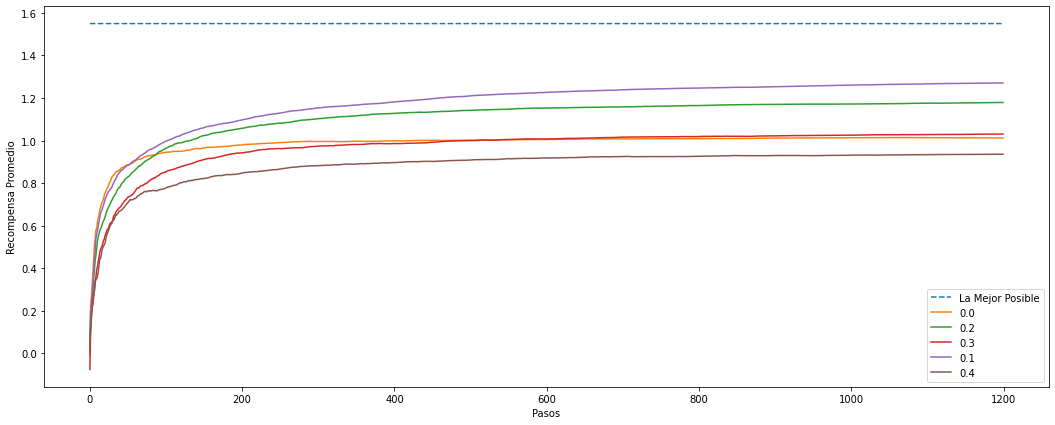

In [13]:
epsilons = [0.0, 0.2,0.3, 0.1, 0.4]

plt.figure(figsize=(18, 7))
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 170

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = eGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        my_best_action = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))

        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
y4=reward
plt.legend(["La Mejor Posible"] + epsilons)
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.show()